<a href="https://colab.research.google.com/github/munich-ml/BER_tail_fit/blob/main/BER_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup Jupyter
Required Python imports


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special
from scipy.stats import norm
from IPython.display import Image

In [2]:
np.random.seed(22)

In [40]:
def show_image(image_name, **kwargs):
    """helper function returning the complete URL <str> for images of this repository"""
    url = "https://github.com/munich-ml/BER_tail_fit/blob/main/images/{}.png?raw=true".format(image_name)
    if "width" not in kwargs:
        kwargs["width"] = 700     # default width
    return Image(url=url, **kwargs)

# Introduction to Jitter

**Jitter** is the **timing uncertainty** of signal edges at the crossing point with their reference level (0V for differential signaling).

Since **Noise** describes a level uncertainty, **timing noise** or **phase noise** (usually used in frequency domain).

In [42]:
show_image("eye1t")

# Measure Jitter using a Scope

In [5]:
x = np.linspace(-1/3, 4/3, num=500)
scale = 0.05    # sigmal value of the gaussian distribution
norm_pdf = norm.pdf(x, loc=0, scale=scale) + norm.pdf(x, loc=1, scale=scale) 
norm_pdf = norm_pdf / norm_pdf.max()

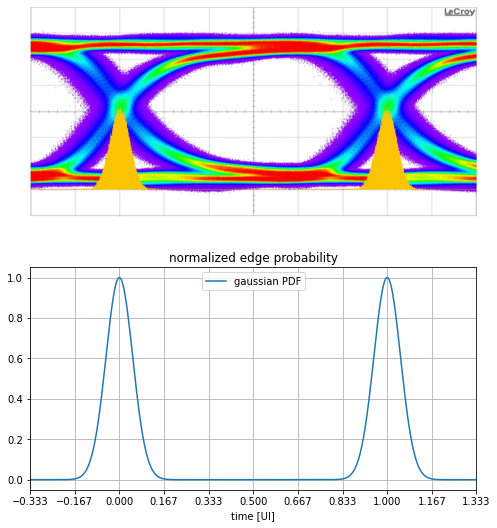

In [51]:
plt.figure(figsize=(8, 9))
plt.subplot(2,1,1)
plt.imshow(plt.imread(image("eye1p")))
plt.axis("off")

plt.subplot(2,1,2)
plt.plot(x, norm_pdf, label="gaussian PDF")
plt.xlim([min(x), max(x)]), plt.xticks(np.linspace(-1/3, 4/3, num=11))
plt.xlabel("time [UI]"), plt.title("normalized edge probability")
plt.grid(), plt.legend();

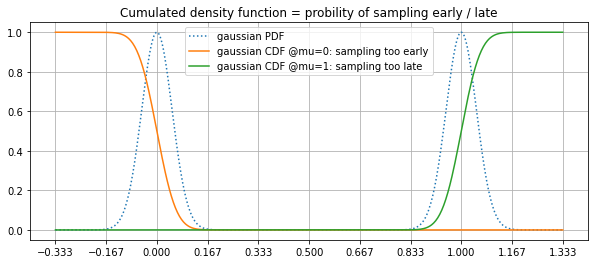

In [7]:
plt.figure(figsize=(10, 4))
too_early = 1 - norm.cdf(x, loc=0, scale=scale) 
too_late = norm.cdf(x, loc=1, scale=scale) 
plt.plot(x, norm_pdf, ":", label="gaussian PDF")
plt.plot(x, too_early, label="gaussian CDF @mu=0: sampling too early")
plt.plot(x, too_late, label="gaussian CDF @mu=1: sampling too late")
# plt.yscale("log"), plt.ylim([1e-12, 1])
plt.xticks(np.linspace(-1/3, 4/3, num=11))
plt.title("Cumulated density function = probility of sampling early / late")
plt.grid(), plt.legend();

# Measure Jitter using a BERT

## Transmitter

#### Simulation constants

In [8]:
N = int(4e5)      # number of simulated bits
DR = 1e9          # data rate [bits/s]
UI = 1/DR         # unit interval [s]
RJ_SIGMA = 0.025  # simulated random jitter's sigma
PJ_FREQ = 3e5     # frequency of the periodic jitter
PJ_AMPL = 0.1     # periodic jitter amplitude [UI]

### RJ, DJ, TJ simulation

In [9]:
t = np.linspace(start=0, stop=(N-1)*UI, num=N)   # time vector
dj = PJ_AMPL * np.sin(2 * np.pi * PJ_FREQ * t)   # determistic jitter,  consists of PJ, only
rj = RJ_SIGMA * np.random.randn(N)               # random jitter
tj = rj + dj                                     # total jitter

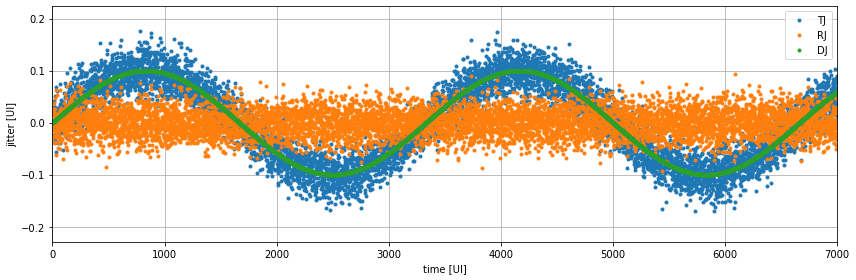

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(tj, ".", label="TJ");
plt.plot(rj, ".", label="RJ");
plt.plot(dj, ".", label="DJ");
plt.xlabel("time [UI]"), plt.ylabel("jitter [UI]")
plt.xlim([0, 7000])
plt.legend(), plt.grid(), plt.tight_layout();

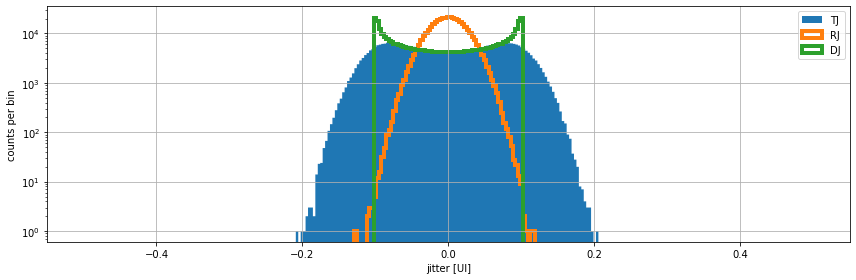

In [11]:
bins = np.linspace(-0.5, 0.5, 300)
plt.figure(figsize=(12, 4))
plt.hist(tj, bins=bins, histtype="stepfilled", label="TJ")
plt.hist(rj, bins=bins, histtype="step", linewidth=4, label="RJ")
plt.hist(dj, bins=bins, histtype="step", linewidth=4, label="DJ")
plt.yscale("log")
plt.ylabel("counts per bin"), plt.xlabel("jitter [UI]")
plt.legend(), plt.grid(), plt.tight_layout();

### Random bit sequence as data

In [12]:
data = np.random.randint(0, 2, N)

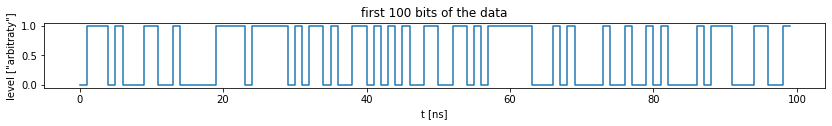

In [13]:
plt.figure(figsize=(14, 1.2))
n = 100    # number of bits shown
sns.lineplot(x=t[:n]*1e9, y=data[:n], drawstyle='steps-post')
plt.title(f"first {n} bits of the data")
plt.xlabel("t [ns]"), plt.ylabel('level ["arbitraty"]');

## Receiver

### Data sampling and error checking
Create a receiver sampler with `65` steps within the unit interval

In [14]:
RX_PI_STEPS = 65          # step count of the receiver phase interpolator
rx_pi = np.linspace(0, 1, num=RX_PI_STEPS)

Cheching for errors

In [15]:
errors = []
for rx_pi_step in rx_pi:
    errors.append(0)      # start with 0 errors at each new RX PI step
    for i, tj_sample in enumerate(tj):
        if 0 < i < N-1:                      # allows sampling data[i-1], data[i+1] 
            if tj_sample > rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i-1], data[i]))
            if 1 + tj_sample < rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i+1], data[i]))

### Compute and plot BER

In [16]:
ber = np.array(errors) / N

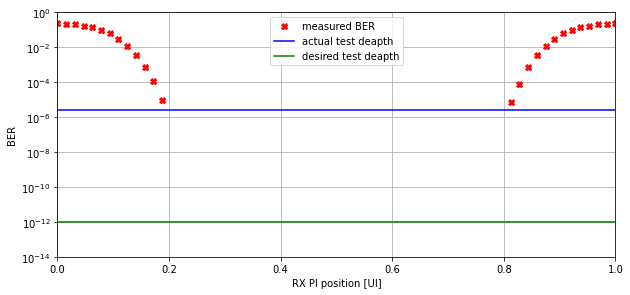

In [17]:
plt.figure(figsize=(10, 4.5))
plt.semilogy(rx_pi, ber, "rX", label="measured BER")
plt.semilogy([0, 1], [1/N, 1/N], "-b", label="actual test deapth")
plt.semilogy([0, 1], [1e-12, 1e-12], "-g", label="desired test deapth")
plt.xlabel("RX PI position [UI]"), plt.ylabel("BER")
plt.xlim([0, 1]), plt.ylim([1e-14, 1])
plt.legend(), plt.grid();